In [22]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
from pymc.util import get_value_vars_from_user_vars
import arviz as az
import pytensor.tensor as tt
from pytensor import scan
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU
print(pm.__version__)

5.12.0


In [23]:
# Define constants
SIZE = 200
T=200
dt=0.1
NUM_SAMPLES = 100
EPOCHS = 1000
DEBUG = False

In [24]:
import pymc as pm
from pymc.step_methods import CompoundStep, Metropolis
import numpy as np
import pytensor.tensor as pt
import torch

class CustomGANStep(CompoundStep):
    def __init__(self, vars, discriminator, T=200, dt=0.1, debug=False):
        # Create a Metropolis step for each variable
        metropolis_steps = [Metropolis([var]) for var in vars]
        
        # Initialize CompoundStep with these Metropolis steps
        super().__init__(metropolis_steps)

        # Store additional information in a dictionary
        self.gan_info = {
            'discriminator': discriminator,
            'T': T,
            'dt': dt,
            'vars': vars,
            'var_names': [var.name for var in vars]
        }
        self.debug = debug
        if self.debug:
            print(f"Initialized CustomGANStep with variables: {self.gan_info['var_names']}")

    def step(self, point):
        # Get current values
        q = []
        for var in self.gan_info['vars']:
            if var.name in point:
                q.append(point[var.name])
            else:
                # Try to find a matching key (e.g., 'kc21_logodds__' for 'kc21')
                matching_key = next((k for k in point.keys() if k.startswith(var.name)), None)
                if matching_key:
                    q.append(point[matching_key])
                else:
                    raise KeyError(f"Cannot find a matching key for variable {var.name}")
        
        if self.debug:
            print(f"Current params: {q}")

        # Propose new values
        q_new = self.proposal(q)
        if self.debug:
            print(f"Proposed params: {q_new}")

        # Generate synthetic data
        synthetic_data_current = self.generate_synthetic_data(q)
        synthetic_data_proposed = self.generate_synthetic_data(q_new)

        # Get discriminator scores
        current_disc_score = self.get_discriminator_score(synthetic_data_current)
        proposed_disc_score = self.get_discriminator_score(synthetic_data_proposed)

        # Compute acceptance probability
        accept = self.compute_acceptance(point, q_new, current_disc_score, proposed_disc_score)

        # Ensure accept is a scalar float
        accept_prob = float(accept)

        if np.random.random() < accept_prob:
            for var, val in zip(self.gan_info['vars'], q_new):
                if var.name in point:
                    point[var.name] = np.atleast_1d(val)
                else:
                    matching_key = next(k for k in point.keys() if k.startswith(var.name))
                    point[matching_key] = np.atleast_1d(val)
        else:
            for var in self.gan_info['vars']:
                if var.name in point:
                    point[var.name] = np.atleast_1d(point[var.name])
                else:
                    matching_key = next(k for k in point.keys() if k.startswith(var.name))
                    point[matching_key] = np.atleast_1d(point[matching_key])

        # Return the new point and an empty stats dictionary
        return point, {}

    def proposal(self, q):
        return [val + np.random.normal(0, 0.1) for val in q]  # You might want to adjust the step size (0.1)

    def compute_acceptance(self, current_point, proposed_values, current_disc_score, proposed_disc_score):
        current_logp = self.logp(current_point)
        
        proposed_point = current_point.copy()
        for var, val in zip(self.gan_info['vars'], proposed_values):
            if var.name in proposed_point:
                proposed_point[var.name] = val
            else:
                matching_key = next(k for k in proposed_point.keys() if k.startswith(var.name))
                proposed_point[matching_key] = val
        
        proposed_logp = self.logp(proposed_point)

        # Metropolis-Hastings acceptance ratio
        ratio = pt.exp(proposed_logp - current_logp)

        # Incorporate discriminator scores
        ratio = ratio * np.exp(proposed_disc_score - current_disc_score)

        # Ensure ratio is a scalar
        ratio = pt.as_tensor_variable(ratio).eval()

        return min(1, ratio)

    def generate_synthetic_data(self, params):
        if self.debug:
            print(f"Params passed to generate_synthetic_data: {params}")
        params = [float(p) for p in params]  # Convert to float
        return pymc_sim_channel(params, self.gan_info['T'], self.gan_info['dt'], source="torch")

    def get_discriminator_score(self, data):
        if isinstance(data, torch.Tensor):
            data_tensor = data.clone().detach().float().unsqueeze(0)
        else:
            data_tensor = torch.tensor(data).float().unsqueeze(0)
        with torch.no_grad():
            score = self.gan_info['discriminator'](data_tensor).item()
        return score

    def logp(self, point):
        # Calculate the log probability for each variable separately
        logp_sum = 0
        for var in self.gan_info['vars']:
            if var.name in point:
                logp_sum += pm.logp(var, point[var.name]).sum()
            else:
                matching_key = next(k for k in point.keys() if k.startswith(var.name))
                logp_sum += pm.logp(var, point[matching_key]).sum()
        return logp_sum

In [25]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [26]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [27]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [28]:
import pytensor.tensor as tt
from pytensor.scan import scan
from pytensor.tensor.random.utils import RandomStream
import torch
import numpy as np

def pymc_sim_channel(params, T, dt, source="torch"):
    kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21 = params
    eps = 1e-10  # Small constant to avoid zero probabilities
    if source == "pymc":
        zero = tt.constant(0.0)
        one = tt.constant(1.0)
        
        # Convert parameters to PyTensor tensors
        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(tt.as_tensor_variable, 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])

        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: tt.maximum(tt.as_tensor_variable(x), eps), 
                                                                [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        # Create transition matrix
        row1 = tt.stack([1-kc12, kc12, zero, zero])
        row2 = tt.stack([kc21, 1-kc21-kco1, kco1, zero])
        row3 = tt.stack([zero, koc2, 1-koc2-ko12, ko12])
        row4 = tt.stack([zero, zero, ko21, 1-ko21])
        transition_matrix = tt.stack([row1, row2, row3, row4])

        transition_matrix = tt.maximum(transition_matrix, eps)
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = transition_matrix / row_sums
        
        # Create a RandomStream for managing the RNG
        srng = RandomStream()
        
        # Generate random initial state
        initial_state = srng.categorical(tt.ones(4) / 4, size=(1,))
        
        def step(state, transition_probs):
            new_state = srng.categorical(transition_probs[state[0]], size=(1,))
            return new_state
        
        states, _ = scan(
            fn=step,
            outputs_info=initial_state,
            non_sequences=transition_matrix,
            n_steps=SIZE-1
        )
        
        states = tt.concatenate([initial_state, states.flatten()])
        
        # Convert states to channels
        channels = tt.switch(states < 2, zero, one)
        
        # Generate noise
        noise = srng.normal(0, Fnoise, size=(SIZE,))
        
        # Combine channels and noise
        result = tt.stack([channels, channels * scale + offset + noise], axis=-1)
        
        # Return the PyTensor variable directly
        return result


    else:
        # Convert to PyTorch tensors
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: torch.tensor(max(x, eps)), 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        
        # Create transition matrix
        row1 = torch.tensor([1-kc12, kc12, 0, 0])
        row2 = torch.tensor([kc21, 1-kc21-kco1, kco1, 0])
        row3 = torch.tensor([0, koc2, 1-koc2-ko12, ko12])
        row4 = torch.tensor([0, 0, ko21, 1-ko21])
                
        transition_matrix = torch.stack([row1, row2, row3, row4])
        
        # Ensure non-negative values and add small constant
        transition_matrix = torch.clamp(transition_matrix, min=eps)
        
        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(dim=1, keepdim=True)
        transition_matrix = transition_matrix / row_sums
        
        def transition_fn(state):
            probs = transition_matrix[state]
            return torch.distributions.Categorical(probs=probs).sample()
        
        initial_probs = torch.ones(4) / 4  # Equal probability for all initial states
        initial_distribution = torch.distributions.Categorical(probs=initial_probs)
        
        states = [initial_distribution.sample().item()]
        
        for _ in range(SIZE - 1):
            states.append(transition_fn(states[-1]).item())
        
        channels = torch.tensor(states)
        channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
        noise = torch.normal(0, Fnoise, (SIZE,))
        
        res = torch.stack([channels, channels * scale + offset + noise], axis=-1)
        return res

Text(0.5, 1.0, 'torch sim Channel Data')

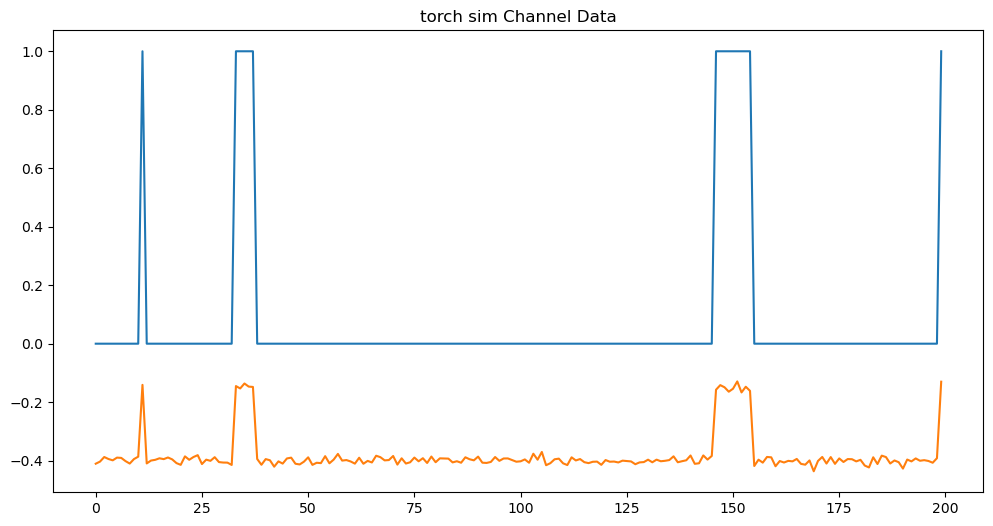

In [29]:
kc12=0.1
kc21=2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
kco2=0.25
ko12=1
ko21=2 
orig_params=[kc12,kc21,Fnoise,scale, offset,kco1,kco2,ko12,ko21]
plt.figure(figsize=(12, 6))
plt.plot(pymc_sim_channel(orig_params, T, dt))
plt.title('torch sim Channel Data')

In [30]:
real_data = torch.stack([pymc_sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_94774/2441911285.py:43: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(samples=1000)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]



Random draw from prior:
ko21: mean = 0.2816, std = 0.1519
koc2: mean = 0.2861, std = 0.1608
ko12: mean = 0.2767, std = 0.1607
Fnoise: mean = 0.8022, std = 0.6105
kc21: mean = 0.2823, std = 0.1686
kco1: mean = 0.2868, std = 0.1582
offset: mean = 0.0493, std = 0.9835
scale: mean = 0.8229, std = 0.6048
kc12: mean = 0.2837, std = 0.1560

Prior distributions:


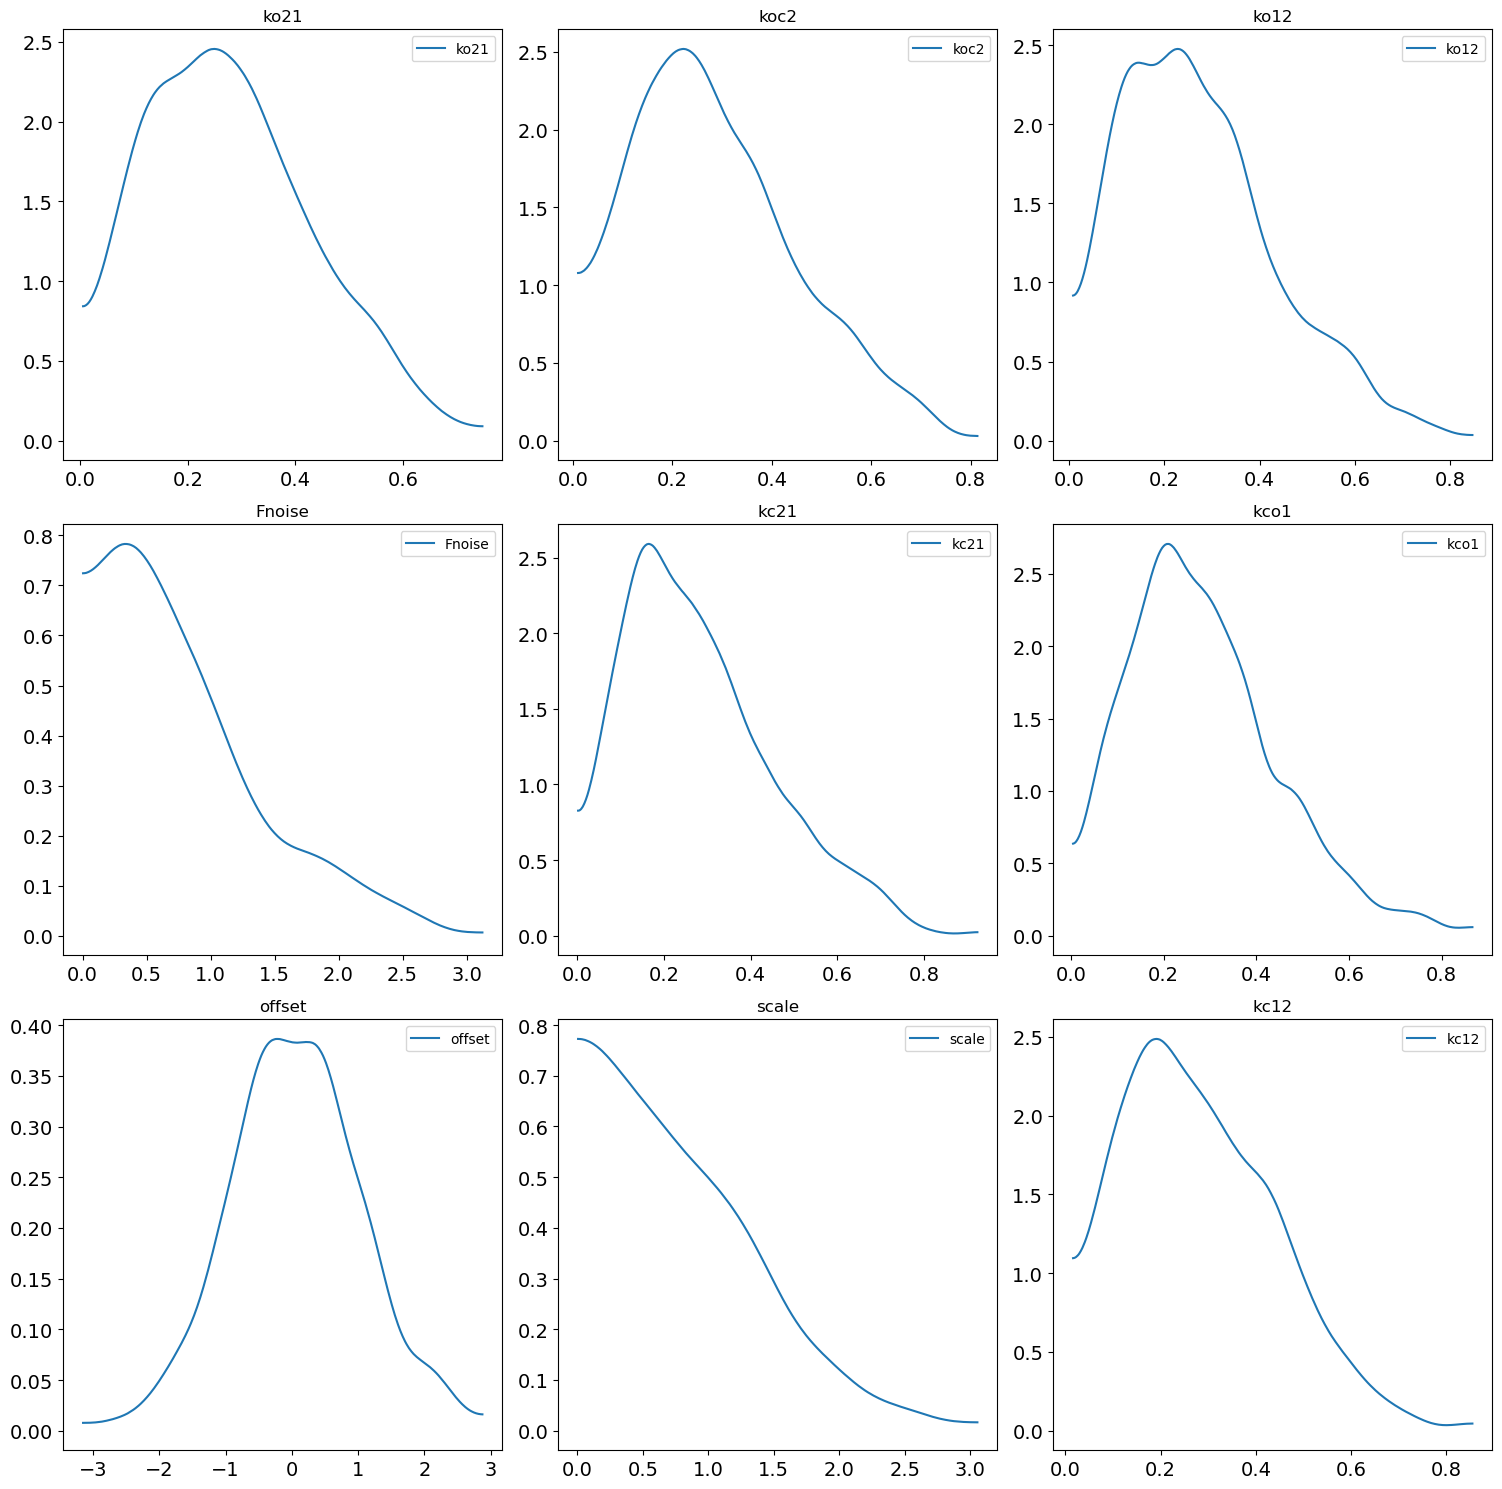


Model created successfully!


In [31]:
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def create_model(T, dt, NUM_SAMPLES):
    with pm.Model() as model:
        # Priors for parameters (using transformed distributions to ensure valid ranges)
        kc21 = pm.Beta('kc21', alpha=2, beta=5)
        kc12 = pm.Beta('kc12', alpha=2, beta=5)
        kco1 = pm.Beta('kco1', alpha=2, beta=5)
        koc2 = pm.Beta('koc2', alpha=2, beta=5)
        ko12 = pm.Beta('ko12', alpha=2, beta=5)
        ko21 = pm.Beta('ko21', alpha=2, beta=5)
        Fnoise = pm.HalfNormal('Fnoise', sigma=1)
        scale = pm.HalfNormal('scale', sigma=1)
        offset = pm.Normal('offset', mu=0, sigma=1)

        # Placeholder for discriminator probabilities
        discriminator_probs = pm.MutableData('discriminator_probs', np.ones(NUM_SAMPLES) * 0.5)

        # Add a small epsilon to avoid log(0) or log(1)
        epsilon = 1e-7
        safe_probs = tt.clip(discriminator_probs, epsilon, 1 - epsilon)

        # Likelihood based on discriminator probabilities
        likelihood = pm.Potential('likelihood', tt.sum(tt.log(safe_probs)))

        # Debugging information
        if DEBUG:
            print("Model structure:")
            for v in model.named_vars.values():
                print(f"{v.name}: {type(v).__name__}")
                if hasattr(v, 'distribution'):
                    print(f"  Distribution: {type(v.distribution).__name__}")
                elif hasattr(v, 'tag'):
                    print(f"  Potential")
                else:
                    print(f"  Type: {type(v)}")

        print("\nRandom draw from prior:")
        prior_predictive = pm.sample_prior_predictive(samples=1000)
        for var_name, value in prior_predictive.prior.items():
            if var_name != 'discriminator_probs':
                print(f"{var_name}: mean = {value.mean().item():.4f}, std = {value.std().item():.4f}")

        print("\nPrior distributions:")
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        for i, (var_name, value) in enumerate(prior_predictive.prior.items()):
            if var_name != 'discriminator_probs':
                az.plot_dist(value, ax=axes[i], label=var_name)
                axes[i].set_title(var_name)
                axes[i].legend()
        plt.tight_layout()
        plt.show()

    return model

# Usage
model = create_model(T, dt, NUM_SAMPLES)
print("\nModel created successfully!")

In [32]:
def generate_synthetic_data(inference_data, num_samples, T, dt):
    # Extract parameters from the InferenceData object
    params = {var: inference_data.prior[var].values.flatten() for var in inference_data.prior.data_vars}
    
    synthetic_data = []
    for i in range(num_samples):
        # Randomly select a set of parameters
        sample_params = [np.random.choice(params[var]) for var in ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']]
        # Generate a single synthetic data sample
        sample = pymc_sim_channel(sample_params, T, dt, source="torch")
        
        synthetic_data.append(sample)
    
    # Stack all samples into a single tensor
    return torch.stack(synthetic_data).float()

In [33]:
def custom_prior_predictive(model, num_samples, discriminator, T, dt):
    with model:
        # Sample from priors
        prior_samples = pm.sample_prior_predictive(samples=num_samples)
    
    # Extract parameter values from prior_samples
    param_values = {}
    for var in model.free_RVs:
        if var.name in prior_samples.prior:
            values = prior_samples.prior[var.name].values
            if values.ndim > 1:
                param_values[var.name] = values.reshape(num_samples, -1)
            else:
                param_values[var.name] = values.reshape(-1, 1)
        else:
            print(f"Warning: {var.name} not found in prior samples. Using random values.")
            param_values[var.name] = np.random.uniform(0, 1, (num_samples, 1))
    
    # Generate synthetic data
    synthetic_data = []
    for i in range(num_samples):
        sample_params = [param_values[var.name][i].flatten()[0] for var in model.free_RVs]
        sample = pymc_sim_channel(sample_params, T, dt, source="torch")
        synthetic_data.append(sample)
    
    synthetic_data = torch.stack(synthetic_data).float()
    
    # Get discriminator probabilities
    with torch.no_grad():
        disc_probs = torch.sigmoid(discriminator(synthetic_data)).numpy()
    
    # Adjust samples based on discriminator probabilities
    adjusted_samples = {}
    for var in model.free_RVs:
        adjusted_samples[var.name] = param_values[var.name] * disc_probs.reshape(-1, 1)
    
    return adjusted_samples

# Usage
prior_predictive = custom_prior_predictive(model, NUM_SAMPLES, discriminator, T, dt)

/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_94774/3717247554.py:4: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_samples = pm.sample_prior_predictive(samples=num_samples)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]


In [ ]:
DEBUG = False  # Set this to True if you want to see debug prints

def print_error(section, e):
    print(f"Error in {section}: {str(e)}")
    print(f"Traceback for {section}:")
    import traceback
    print(traceback.format_exc())

with model:
    print(f"Model variables: {[var.name for var in model.free_RVs]}")
    for epoch in tqdm(range(EPOCHS)):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        try:
            # Generate synthetic data using current model state
            prior_predictive = pm.sample_prior_predictive(samples=NUM_SAMPLES)
            synthetic_data = generate_synthetic_data(prior_predictive, NUM_SAMPLES, T, dt)
        except Exception as e:
            print_error("synthetic data generation", e)
            continue
        
        try:
            # Train discriminator
            real_output = discriminator(real_data)
            fake_output = discriminator(synthetic_data)
            disc_loss = discriminator_loss(real_output, fake_output)
            discriminator_optimizer.zero_grad()
            disc_loss.backward()
            discriminator_optimizer.step()
            print(f"Discriminator Loss: {disc_loss.item()}")
        except Exception as e:
            print_error("discriminator training", e)
            continue
        
        try:
            # Perform MCMC with custom step method
            custom_step = CustomGANStep(vars=model.free_RVs, discriminator=discriminator, T=T, dt=dt, debug=DEBUG)
            print("Starting MCMC sampling with CustomGANStep")
            trace = pm.sample(500, step=custom_step, chains=4, tune=100)
        except Exception as e:
            print_error("MCMC sampling", e)
            continue
        
        try:
            # Print progress
            summary = az.summary(trace)
            print(summary)
        except Exception as e:
            print_error("summary generation", e)
            continue
        
        clear_output(wait=True)

# After training, you can analyze the results
try:
    az.plot_trace(trace)
    plt.show()
except Exception as e:
    print_error("plotting traces", e)

Model variables: ['kc21', 'kc12', 'kco1', 'koc2', 'ko12', 'ko21', 'Fnoise', 'scale', 'offset']


  0%|                                                                                                                          | 0/1000 [00:00<?, ?it/s]/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_94774/3359185563.py:16: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(samples=NUM_SAMPLES)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]



Epoch 1/1000
Discriminator Loss: 1.4049437046051025
Starting MCMC sampling with CustomGANStep


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [kc21]
>Metropolis: [kc12]
>Metropolis: [kco1]
>Metropolis: [koc2]
>Metropolis: [ko12]
>Metropolis: [ko21]
>Metropolis: [Fnoise]
>Metropolis: [scale]
>Metropolis: [offset]


In [ ]:
az.plot_trace(trace)